The purpose of this notebook is to evaluate the performance of Class-wise KMeans and Class-wise CMeans across different datasets.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

# 2 classes 2-D data
X, y = datasets.make_blobs(
    n_samples=[125 * 5, 125 * 2],
    n_features=2,
    centers=[(9.5, 10), (10, 9.4)],
    cluster_std=[[0.6, 0.6], [0.35, 0.3]],
    shuffle=True
)

# # 3 classes 2-D data, with minor class 2
# X, y = datasets.make_blobs(
#     n_samples=[125 * 5, 125 * 2, 15],
#     n_features=2,
#     centers=[(9.5, 10), (10, 9.4),(9,10)],
#     cluster_std=[[0.6, 0.6], [0.35, 0.3], [0.2,0.2]],
#     shuffle=True,
#     random_state=43,
# )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


def optimal_kmeans_by_silhouette(X, k_range=(2, 10), random_state=0, plot=False):
    min_k, max_k = k_range
    silhouette_scores = {}

    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores[k] = score
        if plot:
            print(f"K={k}: Silhouette score = {score:.4f}")

    # 选择最高得分的 k
    best_k = max(silhouette_scores, key=silhouette_scores.get)
    best_model = KMeans(n_clusters=best_k, random_state=random_state).fit(X)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'o-', color='navy')
        plt.axvline(best_k, color='red', linestyle='--', label=f'Best K = {best_k}')
        plt.xlabel("Number of clusters (K)")
        plt.ylabel("Silhouette Score")
        plt.title("Optimal K Selection by Silhouette Coefficient")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return best_k, best_model, silhouette_scores


def optimal_kmeans_by_silhouette_all_class(X, y, k_range=(2, 10), random_state=0, plot=False):
    n_classes = len(np.unique(y))
    clusters_dict = {}
    for i in range(n_classes):
        clusters_dict[i] = optimal_kmeans_by_silhouette(X[y == i], k_range=(2, 10), plot=plot)[0]
    return clusters_dict


n_clusters_per_class = optimal_kmeans_by_silhouette_all_class(X, y, plot=False)
T_total = np.sum(np.array(list(n_clusters_per_class.values())), axis=0)
n_clusters_per_class

{0: 3, 1: 7}

In [3]:
import dbc
from dbc.discretizers import *

loss_matrix = np.array([[0, 2],
                        [1, 0]])

model = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=1.5),
    minmax=True,
    minmax_eps = 1e-5,
    loss_function=loss_matrix,
)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train, loss_function=loss_matrix)
y_pred_test = model.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test, loss_function=loss_matrix)
print(f'Train class condition risk: {conditional_risk_train[0]}')
print(f'Test class condition risk: {conditional_risk_test[0]}')

Train class condition risk: [0.28910891 0.28717949]
Test class condition risk: [0.36666667 0.32727273]


In [4]:
import numpy as np

def cluster_label(X, centers, n_clusters_per_class_dict):
    """
    Assign class labels to samples X based on their nearest cluster centers.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        The input data points.
    centers : np.ndarray, shape (n_centers, n_features)
        Cluster centers.
    n_clusters_per_class_dict : dict
        Dictionary where each key is a class label, and each value is
        the number of clusters for that class.
        Example: {0: 3, 1: 2}.

    Returns
    -------
    labels : np.ndarray, shape (n_samples,)
        Predicted class label for each sample.
    """

    # Step 1: compute pairwise distances between X and centers
    distances = np.linalg.norm(X[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)

    # Step 2: find the nearest center index for each sample
    nearest_center_indices = np.argmin(distances, axis=1)

    # Step 3: assign each center index to a class based on the dictionary
    center_to_class = {}
    start = 0
    for cls, n_clusters in n_clusters_per_class_dict.items():
        end = start + n_clusters
        for idx in range(start, end):
            center_to_class[idx] = cls
        start = end

    # Step 4: map each sample to its class label
    labels = np.array([center_to_class[idx] for idx in nearest_center_indices])

    return labels

Give a first look of compare between no class_wise Kmeans and class_wise Kmeans.

No class-wise Kmeans DBC train class condition risk: [0.21386139 0.14871795]
No class-wise Kmeans DBC test class condition risk: [0.24166667 0.12727273]
class-wise Kmeans DBC train class condition risk: [0.06336634 0.4974359 ]
class-wise Kmeans DBC test class condition risk: [0.11666667 0.50909091]
No class-wise Cmeans DBC train class condition risk: [0.13465347 0.28717949]
No class-wise Cmeans DBC test class condition risk: [0.16666667 0.32727273]
class-wise Cmeans DBC train class condition risk: [0.07722772 0.45128205]
class-wise Cmeans DBC test class condition risk: [0.11666667 0.43636364]
No class-wise Kmeans DMC train class condition risk: [0.21386139 0.14871795]
No class-wise Kmeans DMC test class condition risk: [0.24166667 0.12727273]
class-wise Kmeans DMC train class condition risk: [0.3009901  0.11282051]
class-wise Kmeans DMC test class condition risk: [0.33333333 0.21818182]
No class-wise Cmeans DMC train class condition risk: [0.18019802 0.17435897]
No class-wise Cmeans DM

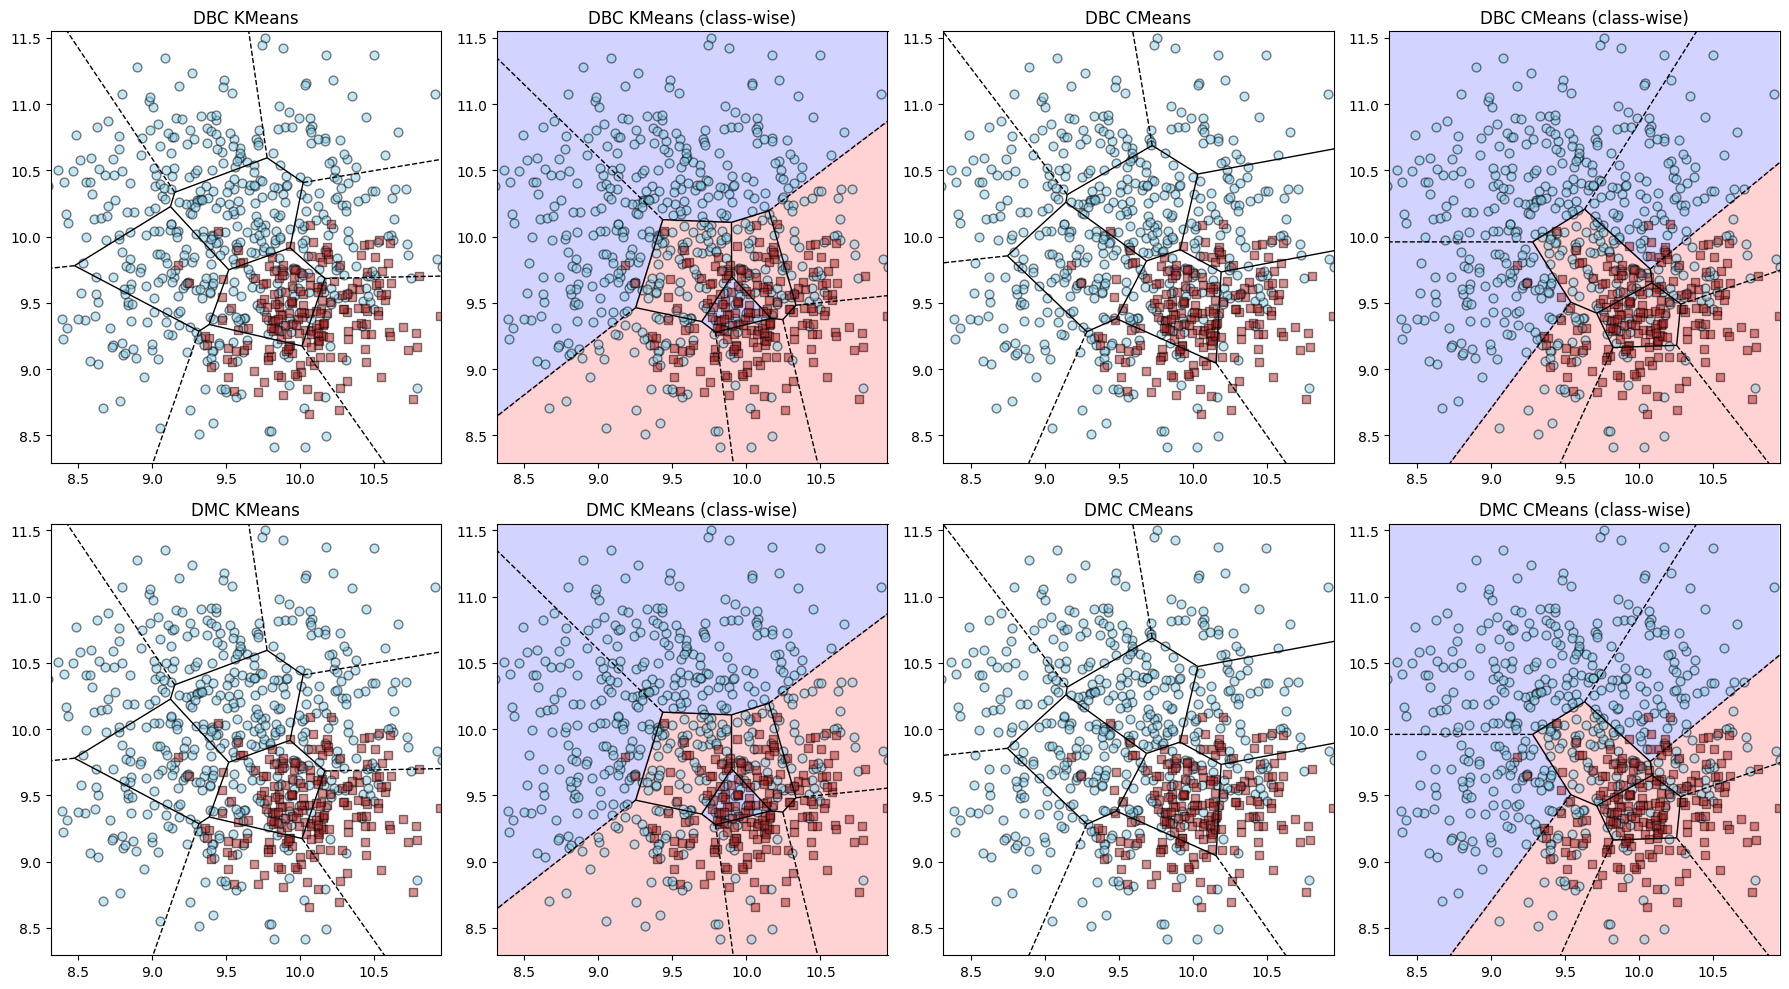

In [11]:
import dbc
from dbc.discretizers import *
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
from matplotlib import pyplot as plt
# Plot the decision regions
n_clusters_per_class = {0: 3, 1: 6}
padding = -0.2
fuzzifier = 1.5

# No class_wise Kmeans
DBC_Kmeans = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansDiscretizer(n_clusters=T_total),
)
DBC_Kmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Kmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Kmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Kmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Kmeans DBC test class condition risk: {conditional_risk_test[0]}')

# class_wise Kmeans
DBC_Kmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class),
)
DBC_Kmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Kmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Kmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Kmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Kmeans DBC test class condition risk: {conditional_risk_test[0]}')

# No class_wise Cmeans
DBC_Cmeans = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansDiscretizer(n_clusters=T_total, fuzzifier=fuzzifier),
)
DBC_Cmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Cmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Cmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Cmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Cmeans DBC test class condition risk: {conditional_risk_test[0]}')

# class_wise Cmeans
DBC_Cmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=fuzzifier),
)
DBC_Cmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Cmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Cmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Cmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Cmeans DBC test class condition risk: {conditional_risk_test[0]}')

# No class_wise Kmeans
DMC_Kmeans = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansDiscretizer(n_clusters=T_total, centers=DBC_Kmeans.discretizer.centers_),
)
DMC_Kmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Kmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Kmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Kmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Kmeans DMC test class condition risk: {conditional_risk_test[0]}')

# class_wise Kmeans
DMC_Kmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, centers=DBC_Kmeans_class_wise.discretizer.centers_),
    minmax=True,
)
DMC_Kmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Kmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Kmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Kmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Kmeans DMC test class condition risk: {conditional_risk_test[0]}')

# No class_wise Cmeans
DMC_Cmeans = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansDiscretizer(n_clusters=T_total, fuzzifier=fuzzifier, centers=DBC_Cmeans.discretizer.centers_),
    minmax=True,
)
DMC_Cmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Cmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Cmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Cmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Cmeans DMC test class condition risk: {conditional_risk_test[0]}')

# class_wise Cmeans
DMC_Cmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=fuzzifier, centers=DBC_Cmeans_class_wise.discretizer.centers_),
    minmax=True,
)
DMC_Cmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Cmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Cmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Cmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Cmeans DMC test class condition risk: {conditional_risk_test[0]}')


fig, ax = plt.subplots(2, 4, figsize=(18, 10))
x_min, x_max = X_train[:, 0].min() - padding, X_train[:, 0].max() + padding
y_min, y_max = X_train[:, 1].min() - padding, X_train[:, 1].max() + padding
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

voronoi_plot_2d(Voronoi(DBC_Kmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[0, 0])
voronoi_plot_2d(Voronoi(DBC_Kmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[0, 1])
voronoi_plot_2d(Voronoi(DBC_Cmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[0, 2])
voronoi_plot_2d(Voronoi(DBC_Cmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[0, 3])

voronoi_plot_2d(Voronoi(DMC_Kmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[1, 0])
voronoi_plot_2d(Voronoi(DMC_Kmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[1, 1])
voronoi_plot_2d(Voronoi(DMC_Cmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[1, 2])
voronoi_plot_2d(Voronoi(DMC_Cmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[1, 3])


Z_DBC_Kmeans = DBC_Kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DBC_Kmeans_class_wise = DBC_Kmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DBC_Cmeans = DBC_Cmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DBC_Cmeans_class_wise = DBC_Cmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DMC_kmeans = DMC_Kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DMC_kmeans_class_wise = DMC_Kmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DMC_Cmeans = DMC_Cmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DMC_Cmeans_class_wise = DMC_Cmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DBC_Kmeans_reshape = np.argmax(Z_DBC_Kmeans, axis=1).reshape(xx.shape)
Z_DBC_Kmeans_class_wise_reshape = np.argmax(Z_DBC_Kmeans_class_wise, axis=1).reshape(xx.shape)
Z_DBC_Cmeans_reshape = np.argmax(Z_DBC_Cmeans, axis=1).reshape(xx.shape)
Z_DBC_Cmeans_class_wise_reshape = np.argmax(Z_DBC_Cmeans_class_wise, axis=1).reshape(xx.shape)
Z_DMC_kmeans_reshape = np.argmax(Z_DMC_kmeans, axis=1).reshape(xx.shape)
Z_DMC_kmeans_class_wise_reshape = np.argmax(Z_DMC_kmeans_class_wise, axis=1).reshape(xx.shape)
Z_DMC_Cmeans_reshape = np.argmax(Z_DMC_Cmeans, axis=1).reshape(xx.shape)
Z_DMC_Cmeans_class_wise_reshape = np.argmax(Z_DMC_Cmeans_class_wise, axis=1).reshape(xx.shape)


# 这里是画出CW情况下每个聚类属于哪个profile的
Z_DBC_Kmeans_class_wise_reshape = cluster_label(np.c_[xx.ravel(), yy.ravel()], DBC_Kmeans_class_wise.discretizer.centers_, n_clusters_per_class).reshape(xx.shape)
Z_DBC_Cmeans_class_wise_reshape = cluster_label(np.c_[xx.ravel(), yy.ravel()], DBC_Cmeans_class_wise.discretizer.centers_, n_clusters_per_class).reshape(xx.shape)
Z_DMC_kmeans_class_wise_reshape = cluster_label(np.c_[xx.ravel(), yy.ravel()], DMC_Kmeans_class_wise.discretizer.centers_, n_clusters_per_class).reshape(xx.shape)
Z_DMC_Cmeans_class_wise_reshape = cluster_label(np.c_[xx.ravel(), yy.ravel()], DMC_Cmeans_class_wise.discretizer.centers_, n_clusters_per_class).reshape(xx.shape)

# contour1 = ax[0, 0].contourf(xx, yy, Z_DBC_Kmeans_reshape, cmap='bwr', alpha=0.2)
# contour3 = ax[0, 2].contourf(xx, yy, Z_DBC_Cmeans_reshape, cmap='bwr', alpha=0.2)
# contour5 = ax[1, 0].contourf(xx, yy, Z_DMC_kmeans_reshape, cmap='bwr', alpha=0.2)
# contour7 = ax[1, 2].contourf(xx, yy, Z_DMC_Cmeans_reshape, cmap='bwr', alpha=0.2)

contour2 = ax[0, 1].contourf(xx, yy, Z_DBC_Kmeans_class_wise_reshape, cmap='bwr', alpha=0.2)
contour4 = ax[0, 3].contourf(xx, yy, Z_DBC_Cmeans_class_wise_reshape, cmap='bwr', alpha=0.2)
contour6 = ax[1, 1].contourf(xx, yy, Z_DMC_kmeans_class_wise_reshape, cmap='bwr', alpha=0.2)
contour8 = ax[1, 3].contourf(xx, yy, Z_DMC_Cmeans_class_wise_reshape, cmap='bwr', alpha=0.2)

# colors for each class
colors = ['skyblue', 'firebrick', 'orange']
markers = ['o', 's', '^']  # circle, square, triangle

# Iterate over all axes and plot training data on each subplot
for row in range(2):
    for col in range(4):
        ax[row, col].set_xlim(x_min, x_max)
        ax[row, col].set_ylim(y_min, y_max)
        ax_current = ax[row, col]
        for i, (c, m) in enumerate(zip(colors, markers)):
            ax_current.scatter(
                X_train[y_train == i, 0],
                X_train[y_train == i, 1],
                color=c,
                edgecolor='k',
                marker=m,
                s=40,
                alpha=0.5,
                label=f'Class {i}'
            )

# Set titles for each subplot
titles = [
    "DBC KMeans", "DBC KMeans (class-wise)", "DBC CMeans", "DBC CMeans (class-wise)",
    "DMC KMeans", "DMC KMeans (class-wise)", "DMC CMeans", "DMC CMeans (class-wise)"
]
for ax_i, title in zip(ax.flat, titles):
    ax_i.set_title(title)

# Optional: add colorbar for consistency
# plt.colorbar(contour2, ax=ax.ravel().tolist(), ticks=[0, 1, 2], label='Predicted class')

plt.tight_layout()
plt.show()


In [78]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from dbc.utils import compute_class_conditional_risk_with_labels


def make_preprocessor(X):
    num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features)
        ]
    )
    return preprocessor


def global_risk(y_true, y_pred):
    return np.mean(y_true != y_pred)


def max_gap(y_true, y_pred):
    R = compute_class_conditional_risk_with_labels(y_true, y_pred)[0]
    return np.max(R) - np.min(R)


def variances_Rk(y_true, y_pred):
    R = compute_class_conditional_risk_with_labels(y_true, y_pred)[0]
    return np.var(R)


def max_Rk(y_true, y_pred):
    R = compute_class_conditional_risk_with_labels(y_true, y_pred)[0]
    return np.max(R)


def print_results(results):
    print("Train global_risk: %.3f (± %.3f)" %
          (-results["train_global_risk"].mean(), results["train_global_risk"].std()))
    print("Train max_Rk: %.3f (± %.3f)" %
          (-results["train_max_Rk"].mean(), results["train_max_Rk"].std()))
    print("Train max_gap: %.3f (± %.3f)" %
          (-results["train_max_gap"].mean(), results["train_max_gap"].std()))
    print("Train variances_Rk: %.3f (± %.3f)" %
          (-results["train_variances_Rk"].mean(), results["train_variances_Rk"].std()))

    print("Test global_risk: %.3f (± %.3f)" %
          (-results["test_global_risk"].mean(), results["test_global_risk"].std()))
    print("Test max_Rk: %.3f (± %.3f)" %
          (-results["test_max_Rk"].mean(), results["test_max_Rk"].std()))
    print("Test max_gap: %.3f (± %.3f)" %
          (-results["test_max_gap"].mean(), results["test_max_gap"].std()))
    print("Test variances_Rk: %.3f (± %.3f)" %
          (-results["test_variances_Rk"].mean(), results["test_variances_Rk"].std()))


scoring = {
    "global_risk": make_scorer(global_risk, greater_is_better=False),
    "max_Rk": make_scorer(max_Rk, greater_is_better=False),
    "max_gap": make_scorer(max_gap, greater_is_better=False),
    "variances_Rk": make_scorer(variances_Rk, greater_is_better=False),
}

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

# df = fetch_ucirepo(id=17)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=15)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=53)  # IRIS
# df = fetch_ucirepo(id=186)  # Wine quality
# df = fetch_ucirepo(id=2)  # Adult
# df = fetch_ucirepo(id=222)  # Bank Marketing
# df = fetch_ucirepo(id=19)  # Car Evaluation(表现很差)

# SPDMC参数似乎是越大越好70 1.4，没测试更高的
# df = fetch_ucirepo(id=59)  # Letter Recognition(不知道为什么这个数据集DMC和SPDMC效果很差,难道是分类类别过多导致的？)
df = fetch_ucirepo(id=149)  # Statlog (Vehicle Silhouettes)(如果SPDMC不收敛记得移除类别只有1个的)

X = df.data.features.replace("?", np.nan)  # Only for adult

X = df.data.features
X = make_preprocessor(X).fit_transform(X)
y = df.data.targets.values.ravel()

# Onlu for Statlog
mask = y != '204'
X = X.iloc[mask] if hasattr(X, 'iloc') else X[mask]
y = y[mask]

y = LabelEncoder().fit_transform(y)

print(f"Number of samples in each classes: {np.bincount(y)}")


n_clusters_per_class = optimal_kmeans_by_silhouette_all_class(X, y)
T_total = np.sum(np.array(list(n_clusters_per_class.values())), axis=0)
# print(f"Total Number of clusters: {T_total}")
n_clusters_per_class

Number of samples in each classes: [217 212 217 199]


{0: 2, 1: 2, 2: 2, 3: 4}

In [26]:
from sklearn.model_selection import cross_validate
from dbc.discretizers.cmeans_class_wise import CMeansClasswiseDiscretizer
from dbc.discretizers.cmeans import CMeansDiscretizer

results_DBC_CMeans_no_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=CMeansDiscretizer(n_clusters=T_total, use_kmeans=True),
        minmax=False,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DMC_CMeans_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=1.3, use_kmeans=True),
        minmax=True,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DMC_CMeans_no_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=CMeansDiscretizer(n_clusters=T_total, use_kmeans=True),
        minmax=True,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DBC_CMeans_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=1.3, use_kmeans=True),
        minmax=False,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DBC_KMeans_no_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=KMeansDiscretizer(n_clusters=T_total),
        minmax=False,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DBC_KMeans_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=KMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class),
        minmax=False,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DMC_KMeans_no_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=KMeansDiscretizer(n_clusters=T_total),
        minmax=True,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

results_DMC_KMeans_class_wise = cross_validate(
    dbc.DiscreteBayesianClassifier(
        discretizer=KMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class),
        minmax=True,
    ),
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# 创建基础模型
base_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# 创建网格搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring={"max_gap": make_scorer(max_gap, greater_is_better=False)},  # 使用你定义的scoring
    cv=rskf,  # 使用你的交叉验证策略
    n_jobs=-1,  # 使用所有CPU核心
    verbose=1,  # 显示进度
    refit='max_gap',
)

# 执行搜索
grid_search.fit(X, y)

# 获取最佳参数和结果
print("最佳参数:")
print(grid_search.best_params_)
print("\n最佳分数:")
print(grid_search.best_score_)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_
results_WLR = cross_validate(
    best_model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
print('WLR results:')
print_results(results_WLR)

Fitting 100 folds for each of 6 candidates, totalling 600 fits
最佳参数:
{'C': 100, 'penalty': 'l2'}

最佳分数:
-0.4565798689624952
WLR results:
Train global_risk: 0.221 (± 0.001)
Train max_Rk: 0.506 (± 0.008)
Train max_gap: 0.410 (± 0.009)
Train variances_Rk: 0.010 (± 0.000)
Test global_risk: 0.226 (± 0.008)
Test max_Rk: 0.528 (± 0.047)
Test max_gap: 0.457 (± 0.051)
Test variances_Rk: 0.012 (± 0.002)


In [28]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'max_depth': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 35, ],
}

# 创建基础模型
base_model = DecisionTreeClassifier(class_weight='balanced')

# 创建网格搜索
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring={"max_gap": make_scorer(max_gap, greater_is_better=False)},  # 使用你定义的scoring
    cv=rskf,  # 使用你的交叉验证策略
    n_jobs=-1,  # 使用所有CPU核心
    verbose=1,  # 显示进度
    refit='max_gap',
)

# 执行搜索
grid_search.fit(X, y)

# 获取最佳参数和结果
print("最佳参数:")
print(grid_search.best_params_)
print("\n最佳分数:")
print(grid_search.best_score_)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_
results_WDT = cross_validate(
    best_model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
print('WDT results:')
print_results(results_WDT)

Fitting 100 folds for each of 13 candidates, totalling 1300 fits
最佳参数:
{'max_depth': 30}

最佳分数:
-0.19234186039038537
WDT results:
Train global_risk: 0.000 (± 0.000)
Train max_Rk: 0.000 (± 0.000)
Train max_gap: 0.000 (± 0.000)
Train variances_Rk: 0.000 (± 0.000)
Test global_risk: 0.116 (± 0.007)
Test max_Rk: 0.228 (± 0.030)
Test max_gap: 0.193 (± 0.034)
Test variances_Rk: 0.002 (± 0.001)


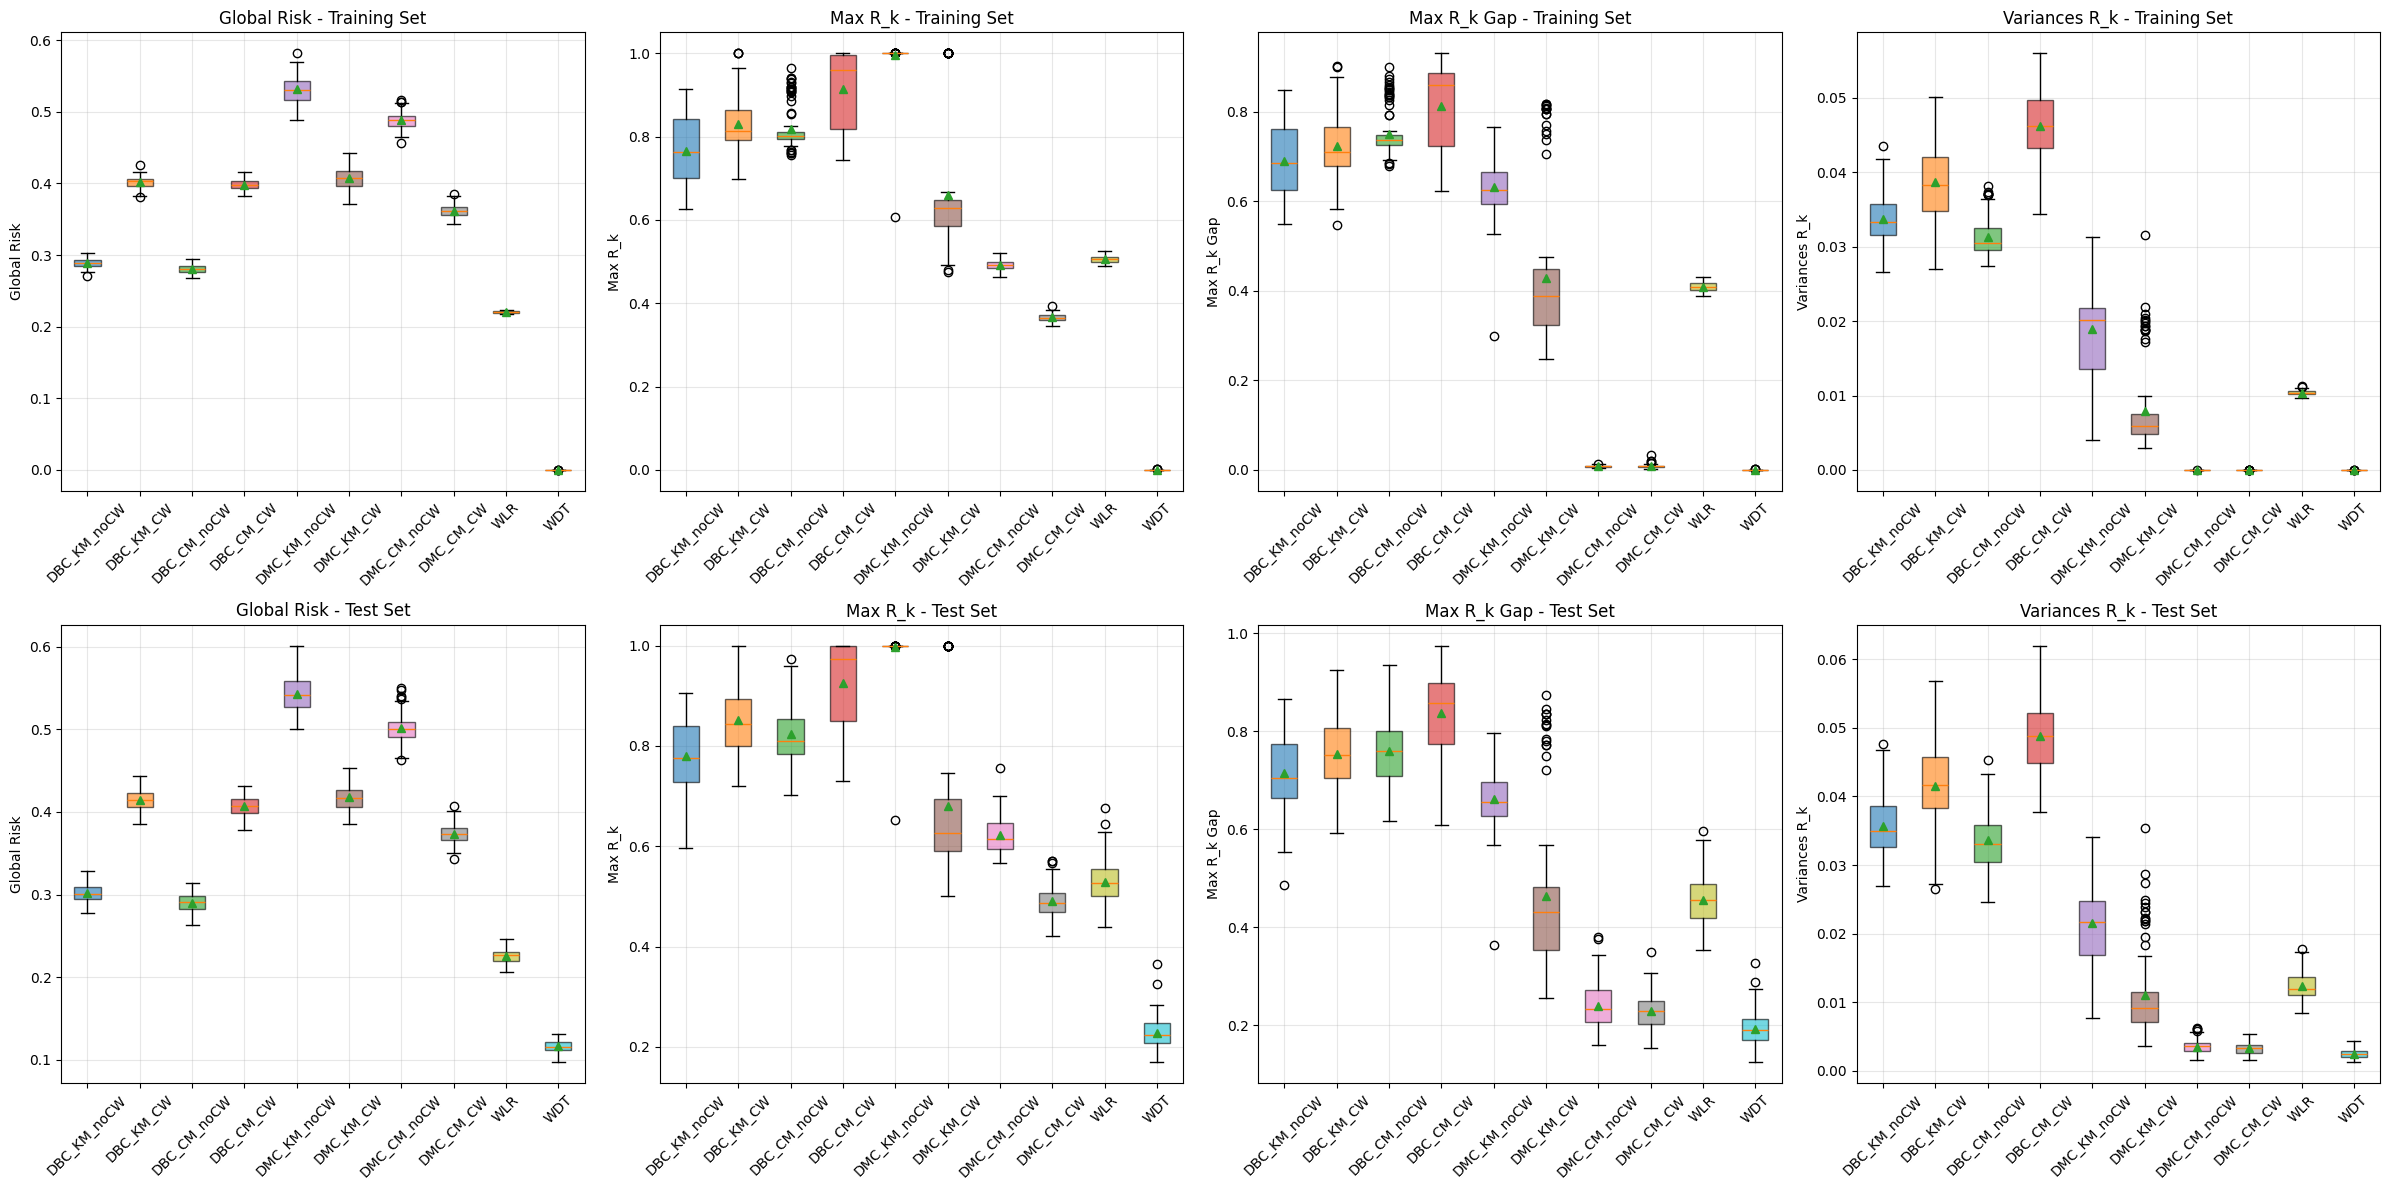

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 收集所有结果
results_dict = {
    'DBC_KM_noCW': results_DBC_KMeans_class_wise,
    'DBC_KM_CW': results_DBC_KMeans_no_class_wise,
    'DBC_CM_noCW': results_DBC_CMeans_class_wise,
    'DBC_CM_CW': results_DBC_CMeans_no_class_wise,

    'DMC_KM_noCW': results_DMC_KMeans_no_class_wise,
    'DMC_KM_CW': results_DMC_KMeans_class_wise,
    'DMC_CM_noCW': results_DMC_CMeans_no_class_wise,
    'DMC_CM_CW': results_DMC_CMeans_class_wise,

    'WLR': results_WLR,
    'WDT': results_WDT,
}

# 定义指标与标签
metrics = ['global_risk', 'max_Rk', 'max_gap', 'variances_Rk']
metric_labels = ['Global Risk', 'Max R_k', 'Max R_k Gap', 'Variances R_k']

# 创建子图
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

# 颜色映射（可自定义）
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#6b6b6b']

# 绘制每个指标
for i, (metric, label) in enumerate(zip(metrics, metric_labels)):

    # ------------------ TRAIN ------------------
    ax_train = axes[i]
    train_data = [-results_dict[model][f"train_{metric}"] for model in results_dict.keys()]  # list of arrays
    bp = ax_train.boxplot(
        train_data,
        patch_artist=True,
        tick_labels=results_dict.keys(),
        showmeans=True,
    )

    # 自定义颜色
    for patch, color in zip(bp['boxes'], colors[:len(train_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    # # 计算均值数值
    # means = [np.median(data) for data in train_data]
    # x_positions = np.arange(1, len(train_data) + 1)
    #
    # # 在图中标出均值数值
    # for x, mean_val in zip(x_positions, means):
    #     ax_train.text(
    #         x, mean_val,                    # 坐标：均值点位置
    #         f'{mean_val:.2f}',              # 显示 4 位小数
    #         ha='center', va='bottom',       # 水平居中，竖直在点上方
    #         fontsize=10, color='black', fontweight='bold'
    #     )
    ax_train.set_title(f"{label} - Training Set")
    ax_train.set_ylabel(label)
    ax_train.grid(True, alpha=0.3)

    # 旋转x轴标签
    ax_train.tick_params(axis='x', labelrotation=45)

    # ------------------ TEST ------------------
    ax_test = axes[i + 4]
    test_data = [-results_dict[model][f"test_{metric}"] for model in results_dict.keys()]
    bp = ax_test.boxplot(
        test_data,
        patch_artist=True,
        tick_labels=results_dict.keys(),
        showmeans=True,
    )

    for patch, color in zip(bp['boxes'], colors[:len(test_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax_test.set_title(f"{label} - Test Set")
    ax_test.set_ylabel(label)
    ax_test.grid(True, alpha=0.3)
    ax_test.tick_params(axis='x', labelrotation=45)

# 调整布局与保存
plt.tight_layout()
plt.savefig(f"./figure/{df['metadata']['name']}_boxplot.pdf", bbox_inches='tight')
plt.show()
